## In Adagrad optimizer there is a big flaw
The Adagrad optimizer is known for its ability to adapt the learning rate for each parameter individually based on the historical gradients. However, one significant flaw of Adagrad is that its learning rate can become excessively small over time. This happens because Adagrad accumulates the squared gradients in the denominator of the update rule. As training progresses, the accumulated sum of squared gradients can grow very large, leading to a situation where the effective learning rate becomes infinitesimally small. This can result in the model stopping learning altogether, as the updates to the parameters become negligible. Consequently, while Adagrad can be effective in the early stages of training, it may struggle to converge to an optimal solution in the long run, especially for deep learning tasks where many iterations are required. To mitigate this issue, alternative optimizers like RMSprop and Adam have been developed, which modify the way the learning rate is adjusted to prevent it from diminishing too quickly.

In [20]:
import numpy as np
import tensorflow as tf

def f(x):
    return x/tf.math.log(x)

x=tf.Variable([364.0])
optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.3)
losses=[]
for i in range(1500):
    with tf.GradientTape() as tape:
        loss=f(x)
    losses.append(loss.numpy())
    gradients=tape.gradient(loss,[x])
    optimizer.apply_gradients(zip(gradients,[x]))


    if i%100==0:
         print(f'Iteration {i}: x = {x.numpy()[0]:.4f}')
print(f'Final result: x = {x.numpy()[0]:.4f}')

Iteration 0: x = 363.0513
Iteration 100: x = 330.9281
Iteration 200: x = 300.8935
Iteration 300: x = 270.8544
Iteration 400: x = 240.8105
Iteration 500: x = 210.7600
Iteration 600: x = 180.7007
Iteration 700: x = 150.6295
Iteration 800: x = 120.5406
Iteration 900: x = 90.4234
Iteration 1000: x = 60.2539
Iteration 1100: x = 29.9579
Iteration 1200: x = 2.7183
Iteration 1300: x = 2.7183
Iteration 1400: x = 2.7183
Final result: x = 2.7183


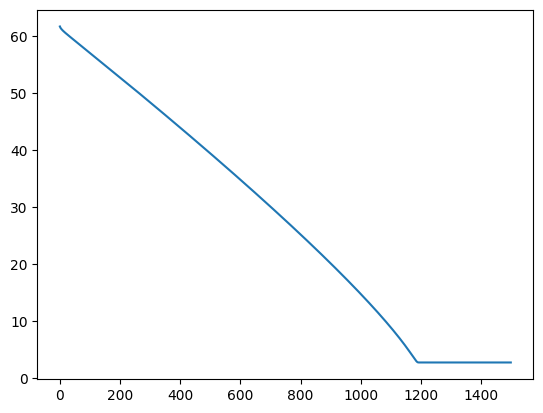

In [21]:
import matplotlib.pyplot as plt


plt.plot(losses[:])

In [ ]:
#  Python implementation
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer


data=load_breast_cancer()
X=data.data.astype(np.float32)
y=data.target.reshape(-1,1).astype(np.float32)

X_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train).astype(np.float32)
x_test=scaler.transform(x_test).astype(np.float32)


X_train_tf=tf.constant(X_train)
x_test_tf=tf.constant(x_test)
y_train_tf=tf.constant(y_train)
y_test_tf=tf.constant(y_test)

n_features=X_train.shape[1]
W=tf.Variable(tf.random.normal([n_features,1],stddev=0.1))
b=tf.Variable(tf.zeros([1]))

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [64]:
# rmsprop hyperparameters
lr=0.01
rho=0.9
eps=1e-8
epochs=500
batch_size=32

# Accumulators for squared gradients

s_W=tf.zeros_like(W)
s_b=tf.zeros_like(b)


# training loop (mini batch)

dataset=tf.data.Dataset.from_tensor_slices((X_train_tf,y_train_tf)).shuffle(1000).batch(batch_size)

losses=[]
for epoch in range(epochs):
    epoch_losses=[]
    for X_batch,y_batch in dataset:
        with tf.GradientTape() as tape:
            logits=tf.matmul(X_batch,W)+b
            probs=tf.sigmoid(logits)

            loss=tf.reduce_mean(-(y_batch * tf.math.log(probs + 1e-9) + (1 - y_batch) * tf.math.log(1 - probs + 1e-9)))
        grads=tape.gradient(loss,[W,b])
        gw,gb=grads[0],grads[1]

        # update running average of squared gradients
        s_W=rho*s_W+(1-rho)*tf.square(gw)
        s_b=rho*s_b+(1-rho)*tf.square(gb)

        W.assign_sub((lr / tf.sqrt(s_W+eps))*gw)
        b.assign_sub((lr / tf.sqrt(s_b+eps))*gb)

        epoch_losses.append(loss.numpy())
    losses.append(np.mean(epoch_losses))

    if epoch % 50 ==0:
        print(f"Epoch {epoch}, Loss: {losses[-1]:.5f}")

Epoch 0, Loss: 0.43927
Epoch 50, Loss: 0.05223
Epoch 100, Loss: 0.04381
Epoch 150, Loss: 0.04220
Epoch 200, Loss: 0.05966
Epoch 250, Loss: 0.03679
Epoch 300, Loss: 0.03558
Epoch 350, Loss: 0.03632
Epoch 400, Loss: 0.03309
Epoch 450, Loss: 0.03155


Test accuracy: 0.9766082167625427


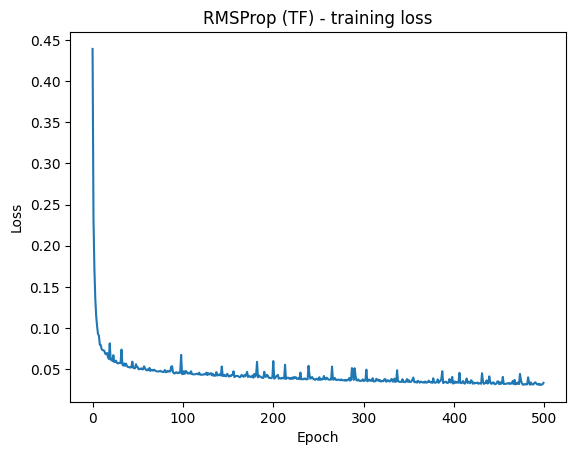

In [65]:
logits_test = tf.matmul(x_test_tf, W) + b
probs_test = tf.sigmoid(logits_test)
preds = tf.cast(probs_test >= 0.5, tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, y_test_tf), tf.float32))
print("Test accuracy:", float(accuracy))

# Plot loss curve
plt.plot(losses)
plt.title("RMSProp (TF) - training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()